In [18]:
import numpy as np
import scipy.sparse as sparse
import spatialpower.neighborhoods.permutationtest as perm_test
import multiprocessing as mp
from datetime import datetime
import errno
from joblib import Parallel, delayed
import os
from glob import glob

from matplotlib_venn import venn3, venn2
import matplotlib.pyplot as plt


In [2]:
def run_test_nosave(A, B, H_gt, size, n_jobs, trials, graph, threshold):
    '''
    Runs the permutation test, and calculates signficant interaction pairs.

    Parameters
    ----------
        size : int, size of graph to calculate.
        n_jobs: int, number of parallel jobs to spawn
        trials: int, number of shuffles in empirical distribution
        plot : bool, generate histogram of each pairwise relation if True.

    Returns
    -------
        enriched_pairs  :   array-like
        depleted_pairs  :   array-like
    '''
   
    n_cell_types = B.shape[1]
    args = (A, B, size, graph, n_cell_types)
    arg_list = [args for i in range(0, trials)]
    results = Parallel(n_jobs=n_jobs, verbose=50, backend="sequential")(
        delayed(perm_test.permutation_test_trial_wrapper)(args) for args in arg_list)
    #parse_results(results, size, out_dir)

    arr = np.dstack(results)  # stack into a 3-D array
    n_types = arr.shape[0]

    enriched_pairs = []
    depleted_pairs = []

    for i in range(0, n_types):
        for j in range(0, n_types):
            ground_truth_score = H_gt[i, j]
            emp_dist = arr[i, j, :]
            indices, = np.where(emp_dist < ground_truth_score)
            p = (len(emp_dist) - len(indices) + 1) / (len(emp_dist) + 1)
            if p <= threshold:
                enriched_pairs.append([i, j, p])
            elif p >= 1 - threshold:
                depleted_pairs.append([i, j, p])

    # Write results matrix.
    #np.save(out_dir + "enriched_pairs.npy", np.array(enriched_pairs))
    #np.save(out_dir + "depleted_pairs.npy", np.array(depleted_pairs))

    return enriched_pairs, depleted_pairs

In [3]:
A = sparse.load_npz('./spleen_data/for_paper/stitched_graph_noblank.npz')
B = np.load('./spleen_data/for_paper/B_full_image_heuristic_4.npy')
p = np.divide(np.sum(B, axis=0), A.shape[0])
H_gt = perm_test.calculate_neighborhood_distribution_sparse(A, B)

/Users/ethan/Dropbox (MIT)/Lab/spatial-data-generation_brokengit/circle_packing/spatialpower/neighborhoods/permutationtest.py:177: RuntimeWarning: divide by zero encountered in true_divide
  aux2 = 1/cell_type_counts


In [240]:
enrichment_pairs, avoidance_pairs = run_test_nosave(A, B, H_gt, A.shape[0], n_jobs=10, trials=1000, graph=composite_graph, threshold = 0.1)

[Parallel(n_jobs=10)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of   3 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of   4 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of   6 | elapsed:    5.7s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of   7 | elapsed:    6.6s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of   8 | elapsed:    7.6s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of   9 | elapsed:    8.6s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    9.6s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  11 | elapsed:   10.5s remaining:    0.0s
[Parallel(n_jobs=10)]: Done

In [242]:
#b = a[a[:,2].argsort()]
enrichment_pair_arr = np.array(enrichment_pairs)
enrichment_pair_arr_sorted = enrichment_pair_arr[enrichment_pair_arr[:,2].argsort()]
np.save('./spleen_data/for_paper/image4_enrichments.npy', enrichment_pair_arr_sorted[enrichment_pair_arr_sorted[:,2] < 0.01])

In [4]:
enrichment_pairs_1 = np.load('./spleen_data/for_paper/image1_enrichments.npy')
enrichment_pairs_2 = np.load('./spleen_data/for_paper/image2_enrichments.npy')
enrichment_pairs_3 = np.load('./spleen_data/for_paper/image3_enrichments.npy')
enrichment_pairs_4 = np.load('./spleen_data/for_paper/image4_enrichments.npy')

In [5]:
enrichment_pairs_list_1 = enrichment_pairs_1[:, :2].astype(int).tolist()
enrichment_pairs_list_2 = enrichment_pairs_2[:, :2].astype(int).tolist()
enrichment_pairs_list_3 = enrichment_pairs_3[:, :2].astype(int).tolist()
enrichment_pairs_list_4 = enrichment_pairs_3[:, :2].astype(int).tolist()

In [6]:
enrichment_pairs_list_1.remove([27,27])
enrichment_pairs_list_2.remove([27,27])
enrichment_pairs_list_3.remove([27,27])
enrichment_pairs_list_4.remove([27,27])

In [8]:
#Convert pairs to pair IDs
pair_id_dict = dict()

id_counter = 0
for i in range(0, 27):
    for j in range(0,27):
        pair_id_dict[(i,j)] = id_counter
        id_counter += 1

In [9]:
def parse_arr_to_tuple(l):
    res = []
    for i in l:
        x = i[0]
        y = i[1]
        res.append((x,y))
    return res

In [10]:
enrichment_pairs_tuples_1 = parse_arr_to_tuple(enrichment_pairs_list_1)
enrichment_pairs_tuples_2 = parse_arr_to_tuple(enrichment_pairs_list_2)
enrichment_pairs_tuples_3 = parse_arr_to_tuple(enrichment_pairs_list_3)
enrichment_pairs_tuples_4 = parse_arr_to_tuple(enrichment_pairs_list_4)

In [11]:
x = set(enrichment_pairs_tuples_1).union(enrichment_pairs_tuples_3)

In [12]:
set(enrichment_pairs_tuples_2).difference(x)

{(0, 25),
 (2, 2),
 (2, 3),
 (3, 2),
 (3, 4),
 (3, 5),
 (3, 8),
 (3, 10),
 (3, 14),
 (3, 19),
 (3, 20),
 (3, 21),
 (4, 3),
 (4, 26),
 (5, 3),
 (5, 14),
 (5, 24),
 (6, 26),
 (7, 11),
 (8, 3),
 (8, 26),
 (9, 3),
 (10, 2),
 (10, 3),
 (11, 3),
 (11, 6),
 (11, 7),
 (11, 12),
 (11, 26),
 (12, 11),
 (12, 20),
 (14, 3),
 (14, 5),
 (16, 26),
 (19, 1),
 (19, 3),
 (19, 20),
 (19, 26),
 (20, 3),
 (20, 12),
 (20, 19),
 (20, 26),
 (21, 3),
 (21, 26),
 (24, 5),
 (25, 0),
 (26, 4),
 (26, 6),
 (26, 16),
 (26, 19),
 (26, 20),
 (26, 21)}

## Compare to real data

In [13]:
A = sparse.load_npz('./spleen_data/for_paper/A_full_balbc3.npz') #BALBC-1
B = np.load('./spleen_data/for_paper/B_full_balbc3.npy')
p = np.divide(np.sum(B, axis=0), A.shape[0])
H_gt = perm_test.calculate_neighborhood_distribution_sparse(A, B)

/Users/ethan/Dropbox (MIT)/Lab/spatial-data-generation_brokengit/circle_packing/spatialpower/neighborhoods/permutationtest.py:170: RuntimeWarning: divide by zero encountered in true_divide
  aux1 = 1/edge_count_by_node


In [261]:
enrichment_pairs, avoidance_pairs = run_test_nosave(A, B, H_gt, A.shape[0], n_jobs=10, trials=1000, graph=nx.from_scipy_sparse_matrix(A), threshold = 0.1)

[Parallel(n_jobs=10)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of   3 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of   4 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:    3.9s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of   6 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of   7 | elapsed:    5.5s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of   8 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of   9 | elapsed:    7.1s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    7.8s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  11 | elapsed:    8.6s remaining:    0.0s
[Parallel(n_jobs=10)]: Done

In [262]:
enrichment_pair_arr = np.array(enrichment_pairs)
enrichment_pair_arr_sorted = enrichment_pair_arr[enrichment_pair_arr[:,2].argsort()]
np.save('./spleen_data/for_paper/balbc3_enrichments.npy', enrichment_pair_arr_sorted[enrichment_pair_arr_sorted[:,2] < 0.01])

In [14]:
balbc1 = np.load('./spleen_data/for_paper/balbc1_enrichments.npy')
balbc2 = np.load('./spleen_data/for_paper/balbc2_enrichments.npy')
balbc3 = np.load('./spleen_data/for_paper/balbc3_enrichments.npy')

In [15]:
balbc1_pairs_list = balbc1[:, :2].astype(int).tolist()
balbc2_pairs_list = balbc2[:, :2].astype(int).tolist()
balbc3_pairs_list = balbc3[:, :2].astype(int).tolist()

In [16]:
balbc1_enrichment_pairs_tuples = parse_arr_to_tuple(balbc1_pairs_list)
balbc2_enrichment_pairs_tuples = parse_arr_to_tuple(balbc2_pairs_list)
balbc3_enrichment_pairs_tuples = parse_arr_to_tuple(balbc3_pairs_list)



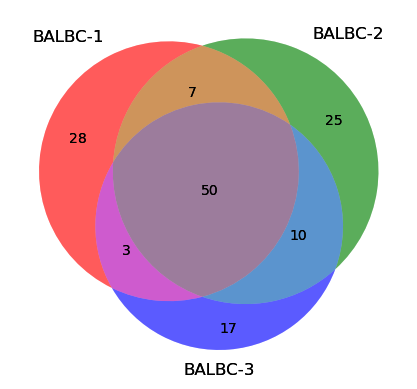

In [19]:
venn3((set(balbc1_enrichment_pairs_tuples), set(balbc2_enrichment_pairs_tuples), set(balbc3_enrichment_pairs_tuples)), set_labels=('BALBC-1', 'BALBC-2', 'BALBC-3'))
#plt.savefig('./spleen_data/figures/BALBC_RST_venn.pdf')
plt.show()

## Stitch together shuffled tiles

In [20]:
from glob import glob

In [21]:
pals_B_arr_names = np.sort(glob('./spleen_data/for_paper/tiles/239_cell_tiles/shuffling_experiment/B_hueristic_pals*'))
bfollicle_B_arr_names = np.sort(glob('./spleen_data/for_paper/tiles/239_cell_tiles/shuffling_experiment/B_hueristic_bfollicle*'))
redpulp_B_arr_names = np.sort(glob('./spleen_data/for_paper/tiles/239_cell_tiles/shuffling_experiment/B_hueristic_redpulp*'))
marginalzone_B_arr_names = np.sort(glob('./spleen_data/for_paper/tiles/239_cell_tiles/shuffling_experiment/B_hueristic_marginalzone*'))

In [22]:
b_follicle_count = 51
pals_count = 94
red_pulp_count = 174
marginal_zone_count = 69


print("B Follicle Tiles ", b_follicle_count)
print("PALS Tiles ", pals_count)
print("Red Pulp Tiles ", red_pulp_count)
print("Marginal Zone Tiles", marginal_zone_count)

B Follicle Tiles  51
PALS Tiles  94
Red Pulp Tiles  174
Marginal Zone Tiles 69


In [23]:
# Assign the tiles to tissues. 
bfollicle_tiles_per_tissue = np.random.choice(bfollicle_B_arr_names, (20, b_follicle_count), replace=False)
pals_tiles_per_tissue = np.random.choice(pals_B_arr_names, (20, pals_count), replace=False)
redpulp_tiles_per_tissue = np.random.choice(redpulp_B_arr_names, (20, red_pulp_count), replace=False)
marginalzone_tiles_per_tissue = np.random.choice(marginalzone_B_arr_names, (20, marginal_zone_count), replace=False)

In [307]:
for j in range(0, 20):
    tissue_tiles = np.concatenate((bfollicle_tiles_per_tissue[j], pals_tiles_per_tissue[j], 
                                   redpulp_tiles_per_tissue[j], marginalzone_tiles_per_tissue[j]))
    np.random.shuffle(tissue_tiles) #Shuffles in place

    for i in range(0, len(tissue_tiles)):
        B_tile = np.load(tissue_tiles[i])

        if i == 0:
            #This is the first tile. 
            B_composite = B_tile
        else:
            B_composite = np.vstack((B_composite, B_tile))

    np.save('./spleen_data/for_paper/tiles/239_cell_tiles/shuffling_experiment/B_composite_' + str(j) + '.npy',
            B_composite)


### Parse shuffled tiles permutation results

In [3]:
from glob import glob

In [24]:
results_arr = glob('./spleen_data/for_paper/tiles/239_cell_tiles/shuffling_experiment/enriched_pairs*')

In [25]:
def parse_arr_to_tuple(l):
    res = []
    for i in l:
        x = i[0]
        y = i[1]
        res.append((x,y))
    return res

def parse_permutation_test_results(arr_path, alpha=0.01):
    arr = np.load(arr_path)
    sig_ixns = arr[arr[:,2] < alpha]
    sig_ixns_list = sig_ixns[:, :2].astype(int).tolist()
    tuple_list = parse_arr_to_tuple(sig_ixns_list)
    tuple_set = set(tuple_list)
    return tuple_set


In [26]:
results_sets = [parse_permutation_test_results(i) for i in results_arr]

In [27]:
#for each interaction, count in how many tissues it was observed. 
possible_ixns = []
for i in range(0, 27):
    for j in range(0, 27):
        possible_ixns.append((i,j))

ixn_counts = dict(zip(possible_ixns, [0 for x in range(0, len(possible_ixns))]))

In [28]:
for ixn in possible_ixns:
    for result_set in results_sets:
        if ixn in result_set:
            ixn_counts[ixn] += 1

In [29]:
ixn_counts_list = list(ixn_counts.values())

In [30]:
n_tissues_with_interaction, counts = np.unique(ixn_counts_list, return_counts=True)
print(n_tissues_with_interaction)
print(counts)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[405 104  44  24  22  15   2   3   6   5   7   3   5   6   4   5   5  13
   3   4  44]


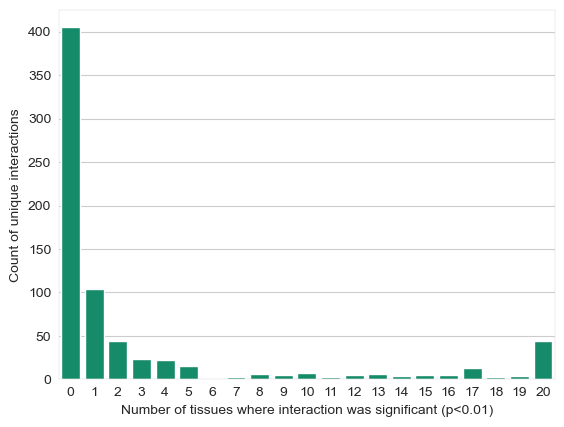

In [32]:
import matplotlib
from matplotlib import cm, colors
import matplotlib.pyplot as plt
import seaborn as sns

matplotlib.rcParams.update({'axes.linewidth': 0.25,
                            'xtick.major.size': 2,
                            'xtick.major.width': 0.25,
                            'ytick.major.size': 2,
                            'ytick.major.width': 0.25,
                            'pdf.fonttype': 42,
                            'font.sans-serif': 'Arial'})
sns.set_style('whitegrid')
sns.barplot(x=n_tissues_with_interaction[:], y=counts[:], color = (2/255, 158/255, 115/255))
plt.ylabel(r'Count of unique interactions')
plt.xlabel(r'Number of tissues where interaction was significant (p<0.01)')
#plt.savefig('./spleen_data/figures/IST_shuffledtiles_overlap_barplot.pdf')
#plt.savefig('./spleen_data/figures/Figure2G.pdf')
plt.show()

### Compare to real data

In [33]:
real_data_all_shared = set.intersection(set(balbc1_enrichment_pairs_tuples), set(balbc2_enrichment_pairs_tuples), set(balbc3_enrichment_pairs_tuples))


In [34]:
ist_data_all_shared = []

for ixn in possible_ixns:
    if ixn_counts[ixn] == 20:
        ist_data_all_shared.append(ixn)

### Binomial Trials

In [38]:
from scipy import stats


/Users/ethan/miniconda3/envs/spleen/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/ethan/miniconda3/envs/spleen/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/ethan/miniconda3/envs/spleen/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error 

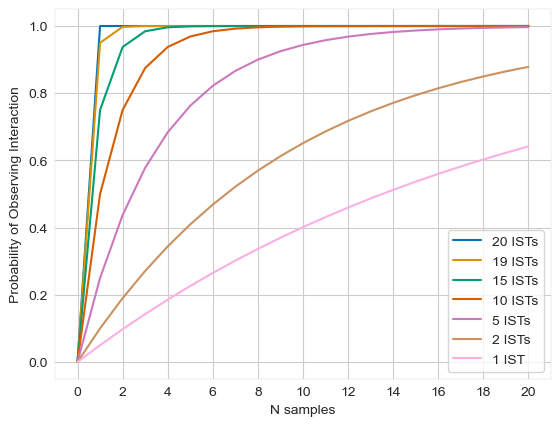

In [40]:
import matplotlib
from matplotlib import cm, colors
import matplotlib.pyplot as plt

matplotlib.rcParams.update({'axes.linewidth': 0.25,
                            'xtick.major.size': 2,
                            'xtick.major.width': 0.25,
                            'ytick.major.size': 2,
                            'ytick.major.width': 0.25,
                            'pdf.fonttype': 42,
                            'font.sans-serif': 'Arial'})
plt.clf()
sns.set_style('whitegrid')
sns.set_palette('colorblind')
x = [i for i in range(0,21)]

sns.lineplot(x, stats.binom.sf(0,x, 1), label = r'20 ISTs')
sns.lineplot(x, stats.binom.sf(0,x, 0.95), label = r'19 ISTs')
sns.lineplot(x, stats.binom.sf(0,x, 0.75), label = r'15 ISTs')
sns.lineplot(x, stats.binom.sf(0,x, 0.50), label = r'10 ISTs')
sns.lineplot(x, stats.binom.sf(0,x, 0.25), label = r'5 ISTs')
sns.lineplot(x, stats.binom.sf(0,x, 0.1), label = r'2 ISTs')
sns.lineplot(x, stats.binom.sf(0,x, 0.05), label = r'1 IST')

plt.xticks([i for i in range(0,21,2)])
plt.ylabel(r"Probability of Observing Interaction")
plt.xlabel(r"N samples")
#plt.savefig('./spleen_data/figures/binomial_probabilities_ISTabundance.pdf')
#plt.savefig('./spleen_data/figures/Figure2I.pdf')
plt.show()

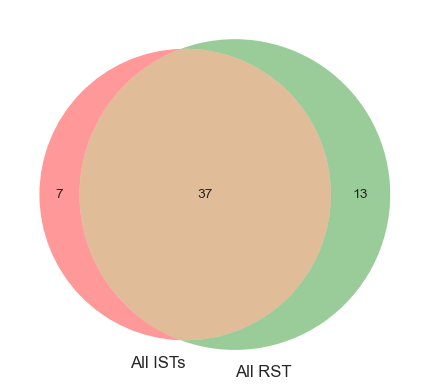

In [42]:
import matplotlib
from matplotlib import cm, colors
import matplotlib.pyplot as plt

matplotlib.rcParams.update({'axes.linewidth': 0.25,
                            'xtick.major.size': 2,
                            'xtick.major.width': 0.25,
                            'ytick.major.size': 2,
                            'ytick.major.width': 0.25,
                            'pdf.fonttype': 42,
                            'font.sans-serif': 'Arial'})

venn2((set(ist_data_all_shared), real_data_all_shared), set_labels=(r'All ISTs', r"All RST") )
#plt.savefig('./spleen_data/figures/IST_RST_comparison.pdf')
#plt.savefig('./spleen_data/figures/Figure2H.pdf')
plt.show()

In [507]:
set(ist_data_all_shared)

{(0, 10),
 (3, 3),
 (3, 26),
 (4, 5),
 (4, 10),
 (5, 4),
 (5, 5),
 (5, 8),
 (5, 10),
 (5, 11),
 (5, 19),
 (5, 21),
 (8, 5),
 (8, 10),
 (9, 9),
 (9, 26),
 (10, 0),
 (10, 4),
 (10, 5),
 (10, 8),
 (10, 10),
 (10, 11),
 (10, 19),
 (10, 21),
 (10, 22),
 (10, 26),
 (11, 5),
 (11, 10),
 (13, 13),
 (13, 15),
 (13, 24),
 (15, 13),
 (15, 15),
 (19, 5),
 (19, 10),
 (21, 5),
 (21, 10),
 (22, 10),
 (24, 13),
 (24, 15),
 (26, 3),
 (26, 9),
 (26, 10),
 (26, 26)}